# 1. Get Tweets related to COVID-19 with Twitter API using Tweepy

**Twitter API imposes a Data rate limitation and hence this code is run persistenlty with waiting times (setting parameters wait_on_rate_limit=True, wait_on_rate_limit_notify=True, to handle this). (Consider other alternatives if possible)**

In [1]:
pip install vaderSentiment

     |████████████████████████████████| 133kB 8.7MB/s 


In [2]:
import os
import tweepy as tw
import pandas as pd
import csv
import pandas as pd
import glob
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from sklearn.model_selection import train_test_split
import keras.models
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras import backend as K

In [3]:
analyser = SentimentIntensityAnalyzer()

In [ ]:
#Enter your keys here
consumer_key= ''
consumer_secret= ''
access_token= ''
access_token_secret= ''

In [ ]:
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [ ]:
search_words = '#COVIDー19 -filter:retweets'
date_since_1 = "2020-10-01"
date_since_2 = "2020-10-20"
date_since_3 = "2020-11-01"
date_since_4 = "2020-11-20"
date_since_5 = "2020-04-01"
date_since_6 = "2020-04-10"
date_since_7 = "2020-04-20"
date_since_8 = "2020-05-01"
date_since_9 = "2020-05-10"
date_since_10 = "2020-05-20"
date_since_11 = "2020-06-01"
date_since_12 = "2020-06-10"
date_since_13 = "2020-06-20"
date_since_14 = "2020-07-01"
date_since_15 = "2020-07-10"
date_since_16 = "2020-07-20"
date_since_17 = "2020-08-01"
date_since_18 = "2020-08-10"
date_since_19 = "2020-08-20"
date_since_20 = "2020-09-01"
date_list = [date_since_9, date_since_10, date_since_11, date_since_12, date_since_13, date_since_14, date_since_15, date_since_16, date_since_17, date_since_18, date_since_19, date_since_20]

In [ ]:
# Function to Collect tweets. Iterator returned.
def tweet_extractor(api, search_words, since_date):
  tweets = tw.Cursor(api.search,
              q=search_words,
              lang="en",
              since=since_date).items(3000)
  return tweets

In [ ]:
#function to create the covid19 csv file
def create_covid19_csv_data(csv_name, dict_list):
  field_names= ['Tweet_Id', 'Tweet_Text']

  with open(csv_name, 'w') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=field_names)
    writer.writeheader()
    writer.writerows(dict_list)

In [ ]:
#Function to persistently create covid-19 data in seperate csv files
def tweet_machine(api,search_words,date_list):
  for date_since in date_list:
    tweets = tweet_extractor(api=api, search_words=search_words, since_date=date_since)
    tweet_dict_list = [{'Tweet_Id':tweet.id, 'Tweet_Text':tweet.text} for tweet in tweets]
    csv_name = 'Tweets_COVID_19_Data_'+ date_since + '.csv'
    create_covid19_csv_data(csv_name=csv_name, dict_list=tweet_dict_list)
    tweet_dict_list.clear()

In [ ]:
tweet_machine(api=api, search_words=search_words, date_list=date_list)

Rate limit reached. Sleeping for: 853
Rate limit reached. Sleeping for: 850
Rate limit reached. Sleeping for: 853
Rate limit reached. Sleeping for: 852
Rate limit reached. Sleeping for: 853
Rate limit reached. Sleeping for: 853
Rate limit reached. Sleeping for: 852
Rate limit reached. Sleeping for: 853
Rate limit reached. Sleeping for: 852
Rate limit reached. Sleeping for: 853
Rate limit reached. Sleeping for: 852
Rate limit reached. Sleeping for: 852
Rate limit reached. Sleeping for: 851


# 2. Data Cleaning

**Concatenate all csv files into one large corpus**

In [3]:
def create_data_corpus(path):
  files = glob.glob(path + "/*.csv")
  df_list = []
  
  for file in files:
    df = pd.read_csv(file, index_col=None, header=0)
    df_list.append(df)

  frame = pd.concat(df_list, axis=0, ignore_index=True)
  return frame

**Remove Duplicate entries**

In [153]:
frame = pd.read_csv('drive/My Drive/Workspace/SentimentAnalysis/TwitterData/Tweets_COVID_19_Data_2020-04-01.csv', index_col=None, header=0)
frame

,Tweet_Id,Tweet_Text
0,1334919241741574145,Listen to RYAN BLISS - LOCKDOWN PARTY VOL 9 (E...
1,1334919173273686019,"""So how did the UK leapfrog the US in the race..."
2,1334918981040435201,I did nazi that coming. #COVIDー19 https://t.co...
3,1334918928502546439,Wearing a fucking mask. #Illinois #COVID19 #CO...
4,1334918870222704643,"Don't ask me why I change ask, yourself what y..."
...,...,...
2995,1334696395576647681,#TheSilenceIsDeafening\n\nThread by @AvrahamCo...
2996,1334696316589514754,Our very own #Hitler in #Florida #DeSantis #CO...
2997,1334696308767158278,#COVIDー19\nImran Khan addressing the United Na...
2998,1334696299107586049,Horrifying. #Nazi @America #ThursdayThoughts N...


In [154]:
frame = frame.drop_duplicates().reset_index(drop=True)
frame

,Tweet_Id,Tweet_Text
0,1334919241741574145,Listen to RYAN BLISS - LOCKDOWN PARTY VOL 9 (E...
1,1334919173273686019,"""So how did the UK leapfrog the US in the race..."
2,1334918981040435201,I did nazi that coming. #COVIDー19 https://t.co...
3,1334918928502546439,Wearing a fucking mask. #Illinois #COVID19 #CO...
4,1334918870222704643,"Don't ask me why I change ask, yourself what y..."
...,...,...
2995,1334696395576647681,#TheSilenceIsDeafening\n\nThread by @AvrahamCo...
2996,1334696316589514754,Our very own #Hitler in #Florida #DeSantis #CO...
2997,1334696308767158278,#COVIDー19\nImran Khan addressing the United Na...
2998,1334696299107586049,Horrifying. #Nazi @America #ThursdayThoughts N...


**Remove Twitter Handles and return handles**

In [4]:
def remove_pattern(input_txt, pattern):
  r = re.findall(pattern, input_txt)
  for i in r:
    input_txt = re.sub(i, '', input_txt)        
  return input_txt

In [156]:
frame['Tweet_clean_Text'] = np.vectorize(remove_pattern)(frame['Tweet_Text'], "RT @[\w]*:")
frame.Tweet_clean_Text = np.vectorize(remove_pattern)(frame['Tweet_clean_Text'], "@[\w]*")
frame

,Tweet_Id,Tweet_Text,Tweet_clean_Text
0,1334919241741574145,Listen to RYAN BLISS - LOCKDOWN PARTY VOL 9 (E...,Listen to RYAN BLISS - LOCKDOWN PARTY VOL 9 (E...
1,1334919173273686019,"""So how did the UK leapfrog the US in the race...","""So how did the UK leapfrog the US in the race..."
2,1334918981040435201,I did nazi that coming. #COVIDー19 https://t.co...,I did nazi that coming. #COVIDー19 https://t.co...
3,1334918928502546439,Wearing a fucking mask. #Illinois #COVID19 #CO...,Wearing a fucking mask. #Illinois #COVID19 #CO...
4,1334918870222704643,"Don't ask me why I change ask, yourself what y...","Don't ask me why I change ask, yourself what y..."
...,...,...,...
2995,1334696395576647681,#TheSilenceIsDeafening\n\nThread by @AvrahamCo...,#TheSilenceIsDeafening\n\nThread by : In the I...
2996,1334696316589514754,Our very own #Hitler in #Florida #DeSantis #CO...,Our very own #Hitler in #Florida #DeSantis #CO...
2997,1334696308767158278,#COVIDー19\nImran Khan addressing the United Na...,#COVIDー19\nImran Khan addressing the United Na...
2998,1334696299107586049,Horrifying. #Nazi @America #ThursdayThoughts N...,Horrifying. #Nazi #ThursdayThoughts NO #COVID...


**Remove URL Links**

In [157]:
frame.Tweet_clean_Text = np.vectorize(remove_pattern)(frame['Tweet_clean_Text'], "https?://[A-Za-z0-9./]*")
frame

,Tweet_Id,Tweet_Text,Tweet_clean_Text
0,1334919241741574145,Listen to RYAN BLISS - LOCKDOWN PARTY VOL 9 (E...,Listen to RYAN BLISS - LOCKDOWN PARTY VOL 9 (E...
1,1334919173273686019,"""So how did the UK leapfrog the US in the race...","""So how did the UK leapfrog the US in the race..."
2,1334918981040435201,I did nazi that coming. #COVIDー19 https://t.co...,I did nazi that coming. #COVIDー19
3,1334918928502546439,Wearing a fucking mask. #Illinois #COVID19 #CO...,Wearing a fucking mask. #Illinois #COVID19 #CO...
4,1334918870222704643,"Don't ask me why I change ask, yourself what y...","Don't ask me why I change ask, yourself what y..."
...,...,...,...
2995,1334696395576647681,#TheSilenceIsDeafening\n\nThread by @AvrahamCo...,#TheSilenceIsDeafening\n\nThread by : In the I...
2996,1334696316589514754,Our very own #Hitler in #Florida #DeSantis #CO...,Our very own #Hitler in #Florida #DeSantis #CO...
2997,1334696308767158278,#COVIDー19\nImran Khan addressing the United Na...,#COVIDー19\nImran Khan addressing the United Na...
2998,1334696299107586049,Horrifying. #Nazi @America #ThursdayThoughts N...,Horrifying. #Nazi #ThursdayThoughts NO #COVID...


**Remove special characters, numbers, punctuations (except for #)**

In [158]:
frame.Tweet_clean_Text = frame.Tweet_clean_Text.str.replace("[^a-zA-Z#]", " ")
frame

,Tweet_Id,Tweet_Text,Tweet_clean_Text
0,1334919241741574145,Listen to RYAN BLISS - LOCKDOWN PARTY VOL 9 (E...,Listen to RYAN BLISS LOCKDOWN PARTY VOL E...
1,1334919173273686019,"""So how did the UK leapfrog the US in the race...",So how did the UK leapfrog the US in the race...
2,1334918981040435201,I did nazi that coming. #COVIDー19 https://t.co...,I did nazi that coming #COVID
3,1334918928502546439,Wearing a fucking mask. #Illinois #COVID19 #CO...,Wearing a fucking mask #Illinois #COVID #CO...
4,1334918870222704643,"Don't ask me why I change ask, yourself what y...",Don t ask me why I change ask yourself what y...
...,...,...,...
2995,1334696395576647681,#TheSilenceIsDeafening\n\nThread by @AvrahamCo...,#TheSilenceIsDeafening Thread by In the Int...
2996,1334696316589514754,Our very own #Hitler in #Florida #DeSantis #CO...,Our very own #Hitler in #Florida #DeSantis #CO...
2997,1334696308767158278,#COVIDー19\nImran Khan addressing the United Na...,#COVID Imran Khan addressing the United Nat...
2998,1334696299107586049,Horrifying. #Nazi @America #ThursdayThoughts N...,Horrifying #Nazi #ThursdayThoughts NO #COVID...


**Remove Extra Spaces**

In [159]:
frame.Tweet_clean_Text = frame.Tweet_clean_Text.replace('\s+', ' ', regex=True)
frame

,Tweet_Id,Tweet_Text,Tweet_clean_Text
0,1334919241741574145,Listen to RYAN BLISS - LOCKDOWN PARTY VOL 9 (E...,Listen to RYAN BLISS LOCKDOWN PARTY VOL EDM BI...
1,1334919173273686019,"""So how did the UK leapfrog the US in the race...",So how did the UK leapfrog the US in the race...
2,1334918981040435201,I did nazi that coming. #COVIDー19 https://t.co...,I did nazi that coming #COVID
3,1334918928502546439,Wearing a fucking mask. #Illinois #COVID19 #CO...,Wearing a fucking mask #Illinois #COVID #COVID...
4,1334918870222704643,"Don't ask me why I change ask, yourself what y...",Don t ask me why I change ask yourself what yo...
...,...,...,...
2995,1334696395576647681,#TheSilenceIsDeafening\n\nThread by @AvrahamCo...,#TheSilenceIsDeafening Thread by In the Intens...
2996,1334696316589514754,Our very own #Hitler in #Florida #DeSantis #CO...,Our very own #Hitler in #Florida #DeSantis #CO...
2997,1334696308767158278,#COVIDー19\nImran Khan addressing the United Na...,#COVID Imran Khan addressing the United Nation...
2998,1334696299107586049,Horrifying. #Nazi @America #ThursdayThoughts N...,Horrifying #Nazi #ThursdayThoughts NO #COVID #...


**Function to carry out data cleaning**

In [5]:
def clean_tweets(frame, column_name):
  frame = frame.drop_duplicates().reset_index(drop=True) #remove duplicate rows
  frame['Tweet_Clean_Text'] = np.vectorize(remove_pattern)(frame[column_name], "RT @[\w]*:") #remove twitter return handle
  frame.Tweet_Clean_Text = np.vectorize(remove_pattern)(frame['Tweet_Clean_Text'], "@[\w]*") #remove twitter handle
  frame.Tweet_Clean_Text = np.vectorize(remove_pattern)(frame['Tweet_Clean_Text'], "https?://[A-Za-z0-9./]*") #remove URLs
  frame.Tweet_Clean_Text = frame.Tweet_Clean_Text.str.replace("[^a-zA-Z#]", " ") #remove special characters except for #
  frame.Tweet_Clean_Text = frame.Tweet_Clean_Text.replace('\s+', ' ', regex=True) #remove extra spaces in between words

  return frame

In [161]:
frame = create_data_corpus('drive/My Drive/Workspace/SentimentAnalysis/TwitterData') #Use your own path, I have mounted the data from google drive
covid_19_frame = clean_tweets(frame,'Tweet_Text')
covid_19_frame

,Tweet_Id,Tweet_Text,Tweet_Clean_Text
0,1334926873944584201,"Government could care less about us, they not ...",Government could care less about us they not g...
1,1334926692574433280,In #UNGA Special Session on #COVIDー19. Listeni...,In #UNGA Special Session on #COVID Listening t...
2,1334926689693028354,THINK!\n#COVID19 \n#COVIDー19 \n#FridayThoughts...,THINK #COVID #COVID #FridayThoughts
3,1334926679442137088,I can see the end of the #cinema. Streaming wi...,I can see the end of the #cinema Streaming wil...
4,1334926669556019200,"#VT News 📰\n04:12:2020\nFor more promotions📜, ...",#VT News For more promotions Legal Notice Foll...
...,...,...,...
4105,1334880135246270464,"As many as 57,405 persons have undergone #Covi...",As many as persons have undergone #Covid tests...
4106,1334910162470047744,This yrars Christmas album #pixieelittle #porn...,This yrars Christmas album #pixieelittle #porn...
4107,1334910064000372736,📌To reassure the public that #COVIDー19 vaccine...,To reassure the public that #COVID vaccines a...
4108,1334909370082189315,This. #COVID19 #COVIDー19 #CovidVaccine #antiv...,This #COVID #COVID #CovidVaccine #antivaxxers ...


# 3. Assign Polarities to the extracted tweets using unsupervised sentiment analysis tools (Data Exploration)

In [133]:
def calculate_sentiment_analyser(Clean_text):    
    return analyser.polarity_scores(Clean_text)

In [134]:
sentiment_frame = pd.DataFrame(index = range(0,len(frame)),columns= ['pos', 'neu', 'neg', 'compound_score', 'sentiment'])

for i, row in covid_19_frame.iterrows():
  sentiment_frame['pos'][i] = analyser.polarity_scores(covid_19_frame.Tweet_clean_Text[i])["pos"]
  sentiment_frame['neu'][i] = analyser.polarity_scores(covid_19_frame.Tweet_clean_Text[i])["neu"]
  sentiment_frame['neg'][i] = analyser.polarity_scores(covid_19_frame.Tweet_clean_Text[i])["neg"]
  sentiment_frame['compound_score'][i] = analyser.polarity_scores(covid_19_frame.Tweet_clean_Text[i])["compound"]

  if (sentiment_frame['compound_score'][i] <= -0.05):
    sentiment_frame['sentiment'][i] = 'Negative'    
  elif (sentiment_frame['compound_score'][i] >= 0.05):
    sentiment_frame['sentiment'][i] = 'Positive'
  elif ((sentiment_frame['compound_score'][i] >= -0.05) & (sentiment_frame['compound_score'][i] <= 0.05)):
    sentiment_frame['sentiment'][i] = 'Neutral'

covid_19_frame['pos'] = sentiment_frame['pos']
covid_19_frame['neu'] = sentiment_frame['neu']
covid_19_frame['neg'] = sentiment_frame['neg']
covid_19_frame['compound_score'] = sentiment_frame['compound_score']
covid_19_frame['sentiment'] = sentiment_frame['sentiment']
covid_19_frame

,Tweet_Id,Tweet_Text,Tweet_clean_Text,pos,neu,neg,compound_score,sentiment
0,1334926873944584201,"Government could care less about us, they not ...",Government could care less about us they not g...,0.253,0.663,0.084,0.6204,Positive
1,1334926692574433280,In #UNGA Special Session on #COVIDー19. Listeni...,In #UNGA Special Session on #COVID Listening t...,0.279,0.721,0,0.7351,Positive
2,1334926689693028354,THINK!\n#COVID19 \n#COVIDー19 \n#FridayThoughts...,THINK #COVID #COVID #FridayThoughts,0,1,0,0,Neutral
3,1334926679442137088,I can see the end of the #cinema. Streaming wi...,I can see the end of the #cinema Streaming wil...,0.167,0.833,0,0.5598,Positive
4,1334926669556019200,"#VT News 📰\n04:12:2020\nFor more promotions📜, ...",#VT News For more promotions Legal Notice Foll...,0.151,0.849,0,0.197,Positive
...,...,...,...,...,...,...,...,...
4105,1334880135246270464,"As many as 57,405 persons have undergone #Covi...",As many as persons have undergone #Covid tests...,0,1,0,0,Neutral
4106,1334910162470047744,This yrars Christmas album #pixieelittle #porn...,This yrars Christmas album #pixieelittle #porn...,0,1,0,0,Neutral
4107,1334910064000372736,📌To reassure the public that #COVIDー19 vaccine...,To reassure the public that #COVID vaccines a...,0.359,0.641,0,0.8126,Positive
4108,1334909370082189315,This. #COVID19 #COVIDー19 #CovidVaccine #antiv...,This #COVID #COVID #CovidVaccine #antivaxxers ...,0,1,0,0,Neutral


In [136]:
covid_19_frame['sentiment'].value_counts()

Positive    1541
Neutral     1373
Negative    1196
Name: sentiment, dtype: int64

# 4. Preprocess the SemEval2017 Dataset for training the Networks. Finetune the networks using the twitter data obtained previously

In [6]:
semeval_frame = create_data_corpus('drive/My Drive/Workspace/SentimentAnalysis/SemEval2017Dataset') #Use your own path, I have mounted the data from google drive
semeval_frame = clean_tweets(semeval_frame, 'Column3')
semeval_frame

,Column1,Column2,Column3,Tweet_Clean_Text
0,4.343150e+17,negative,@MetroNorth wall to wall people on the platfor...,wall to wall people on the platform at South ...
1,4.376050e+17,neutral,ang sarap mging panganay. Pag ikaw may kylngan...,ang sarap mging panganay Pag ikaw may kylngan ...
2,4.374240e+17,negative,RT @katie_rohaley: School on Monday is just go...,School on Monday is just gonna be a great time
3,4.368360e+17,negative,Thanks manager for putting me on the schedule ...,Thanks manager for putting me on the schedule ...
4,4.356710e+17,negative,Who needs sleep? It's not like I have a test t...,Who needs sleep It s not like I have a test to...
...,...,...,...,...
49710,6.820000e+17,neutral,@ShaquilleHoNeal from what I think you're aski...,from what I think you re asking in no order F...
49711,6.820000e+17,positive,"Iran ranks 1st in liver surgeries, Allah bless...",Iran ranks st in liver surgeries Allah bless t...
49712,6.820000e+17,neutral,Hours before he arrived in Saudi Arabia on Tue...,Hours before he arrived in Saudi Arabia on Tue...
49713,6.820000e+17,negative,@VanityFair Alex Kim Kardashian worth how to ...,Alex Kim Kardashian worth how to love Kim Kar...


In [10]:
semeval_frame['Column2'].value_counts()

neutral     22274
positive    19688
negative     7753
Name: Column2, dtype: int64

# Build the Inputs and LSTM network

**Convert everything to lowercase**

In [7]:
semeval_frame['Tweet_Clean_Text'] = semeval_frame['Tweet_Clean_Text'].apply(lambda x: x.lower())
semeval_frame

,Column1,Column2,Column3,Tweet_Clean_Text
0,4.343150e+17,negative,@MetroNorth wall to wall people on the platfor...,wall to wall people on the platform at south ...
1,4.376050e+17,neutral,ang sarap mging panganay. Pag ikaw may kylngan...,ang sarap mging panganay pag ikaw may kylngan ...
2,4.374240e+17,negative,RT @katie_rohaley: School on Monday is just go...,school on monday is just gonna be a great time
3,4.368360e+17,negative,Thanks manager for putting me on the schedule ...,thanks manager for putting me on the schedule ...
4,4.356710e+17,negative,Who needs sleep? It's not like I have a test t...,who needs sleep it s not like i have a test to...
...,...,...,...,...
49710,6.820000e+17,neutral,@ShaquilleHoNeal from what I think you're aski...,from what i think you re asking in no order f...
49711,6.820000e+17,positive,"Iran ranks 1st in liver surgeries, Allah bless...",iran ranks st in liver surgeries allah bless t...
49712,6.820000e+17,neutral,Hours before he arrived in Saudi Arabia on Tue...,hours before he arrived in saudi arabia on tue...
49713,6.820000e+17,negative,@VanityFair Alex Kim Kardashian worth how to ...,alex kim kardashian worth how to love kim kar...


**Change labels to integer as its easier to feed as an input / one hot encode them**

In [8]:
#from sklearn.preprocessing import LabelBinarizer
#lb = LabelBinarizer()

#Solution1
semeval_frame["Sentiment_Value"] = semeval_frame["Column2"].map({"neutral": 0, "positive": 1, "negative": 2})
lbl = to_categorical(semeval_frame["Sentiment_Value"], 3)

#Solution2
#one_hot = pd.get_dummies(semeval_frame['Column2'])
#semeval_frame = semeval_frame.join(one_hot)

#Solution3
#semeval_frame = semeval_frame.join(pd.DataFrame(lb.fit_transform(semeval_frame["Column2"]),
#                          columns=lb.classes_, 
#                          index=semeval_frame.index))
semeval_frame

,Column1,Column2,Column3,Tweet_Clean_Text,Sentiment_Value
0,4.343150e+17,negative,@MetroNorth wall to wall people on the platfor...,wall to wall people on the platform at south ...,2
1,4.376050e+17,neutral,ang sarap mging panganay. Pag ikaw may kylngan...,ang sarap mging panganay pag ikaw may kylngan ...,0
2,4.374240e+17,negative,RT @katie_rohaley: School on Monday is just go...,school on monday is just gonna be a great time,2
3,4.368360e+17,negative,Thanks manager for putting me on the schedule ...,thanks manager for putting me on the schedule ...,2
4,4.356710e+17,negative,Who needs sleep? It's not like I have a test t...,who needs sleep it s not like i have a test to...,2
...,...,...,...,...,...
49710,6.820000e+17,neutral,@ShaquilleHoNeal from what I think you're aski...,from what i think you re asking in no order f...,0
49711,6.820000e+17,positive,"Iran ranks 1st in liver surgeries, Allah bless...",iran ranks st in liver surgeries allah bless t...,1
49712,6.820000e+17,neutral,Hours before he arrived in Saudi Arabia on Tue...,hours before he arrived in saudi arabia on tue...,0
49713,6.820000e+17,negative,@VanityFair Alex Kim Kardashian worth how to ...,alex kim kardashian worth how to love kim kar...,2


**Vectorize and convert text into sequences**

In [9]:
num_features = 2000
tokenizer = Tokenizer(num_words=num_features, split=' ')
tokenizer.fit_on_texts(semeval_frame['Tweet_Clean_Text'].values)
X = tokenizer.texts_to_sequences(semeval_frame['Tweet_Clean_Text'].values)
X = pad_sequences(X, maxlen=200, padding='post')

**Create Training, Validation, and Test Data splits**

In [10]:
#Y = semeval_frame['Sentiment_Value']
Y = lbl

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.15, random_state = 10)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15, random_state=10)

In [11]:
lbl

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

**Define the model**

In [12]:
output_dims = 200
lstm_out = 200

model = keras.Sequential([
    layers.Embedding(input_dim=num_features, output_dim=output_dims, input_length=X.shape[1]),
    layers.SpatialDropout1D(0.2),
    layers.Bidirectional(layers.LSTM(units=lstm_out, dropout=0.2, recurrent_dropout=0.2)),
    layers.Dense(units=3, activation='softmax')
    ])

In [13]:
def recall_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    recall_score.__name__ = 'recall'
    return recall

def precision_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    precision_score.__name__ = 'precision'
    return precision

def f1_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1_metrics.__name__ = 'f1'
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def f1_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1_metrics.__name__ = 'f1_score'
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

metrics = [
           keras.metrics.CategoricalAccuracy(),
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall'),
           f1_metrics,
           #keras.metrics.TruePositives(name='tp'),
           #keras.metrics.FalsePositives(name='fp'),
           #keras.metrics.TrueNegatives(name='tn'),
           #keras.metrics.FalseNegatives(name='fn'),
]

model.compile(optimizer='adam',
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=metrics)

**Useful plot function**

In [22]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [25]:
def plot_metrics(history):
  metrics = ['loss', 'categorical_accuracy', 'precision', 'recall', 'f1_metrics']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,3,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    else:
      plt.ylim([0,1])

    plt.legend()

**Save Model Function**

In [16]:
def save_model(model, path):
  keras.models.save_model(path,save_format='tf')

**Load Model Function**

In [17]:
def load_model(model, path):
  return keras.models.load_model(path)

**Load model weights**

In [18]:
def load_model_weights(model, path):
  model.load_weights(checkpoint_filepath)

**Save only the best weights(determined after every epoch)**

In [19]:
checkpoint_filepath = 'drive/My Drive/Workspace/SentimentAnalysis/Model/Checkpoints'

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True,
    save_freq='epoch')

**Train Model**

In [20]:
history = model.fit(x_train, y_train, epochs = 15, batch_size=1000, validation_data=(x_val,y_val), callbacks=[model_checkpoint_callback])

Epoch 1/15
36/36 [==============================] - 60s 2s/step - loss: 0.9830 - categorical_accuracy: 0.5002 - precision: 0.6135 - recall: 0.1742 - f1_metrics: 0.2315 - val_loss: 0.8881 - val_categorical_accuracy: 0.5810 - val_precision: 0.6403 - val_recall: 0.4420 - val_f1_metrics: 0.5247
Epoch 2/15
36/36 [==============================] - 60s 2s/step - loss: 0.8164 - categorical_accuracy: 0.6194 - precision: 0.6733 - recall: 0.5164 - f1_metrics: 0.5844 - val_loss: 0.7994 - val_categorical_accuracy: 0.6252 - val_precision: 0.6736 - val_recall: 0.5285 - val_f1_metrics: 0.5960
Epoch 3/15
36/36 [==============================] - 61s 2s/step - loss: 0.7473 - categorical_accuracy: 0.6610 - precision: 0.7044 - recall: 0.5819 - f1_metrics: 0.6373 - val_loss: 0.7801 - val_categorical_accuracy: 0.6424 - val_precision: 0.6750 - val_recall: 0.5734 - val_f1_metrics: 0.6206
Epoch 4/15
36/36 [==============================] - 60s 2s/step - loss: 0.7179 - categorical_accuracy: 0.6767 - precision: 0

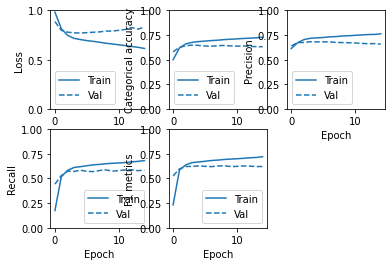

In [26]:
plot_metrics(history)